# 📚 Libraries


In [1]:
import json
import zenml
import torch
import spacy
import transformers
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from zenml.environment import Environment
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import AutoModel, AutoTokenizer, AutoConfig
from huggingface_hub import notebook_login, PyTorchModelHubMixin

# 🥼 Google Colab


In [2]:
if Environment.in_google_colab():
    print(f"🥼 Running on Google Colab")

    from google.colab import drive

    drive.mount("/content/drive")

    data_path = (
        "/content/drive/My Drive/Colab Notebooks/Natural Language Processing/Project"
    )
else:
    data_path = "./"

# 🧑‍💻 CUDA Specification


In [3]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

# 🧘‍♂️ ZenML


In [4]:
# !zenml init

# 📚 Import Data


In [5]:
df_train = pd.read_csv(f"{data_path}/data/train_clean.csv.zip")
df_val = pd.read_csv(f"{data_path}/data/val_clean.csv.zip")
df_test = pd.read_csv(f"{data_path}/data/test_clean.csv.zip")

In [6]:
print(f"🏃‍♂️ Train shape: {df_train.shape}")
print(f"🏋️ Validation shape: {df_val.shape}")
print(f"🧐 Test shape: {df_test.shape}")

🏃‍♂️ Train shape: (5000, 15)
🏋️ Validation shape: (1020, 15)
🧐 Test shape: (1134, 15)


## 📖 Define the data


In [7]:
MODEL_NAME = "bert-base-uncased"
MODEL_TYPE = "bert"
SPACY_MODEL = "en_core_web_sm"

In [8]:
GENRE_MAPPING = {"edm": 0, "r&b": 1, "rap": 2, "rock": 3, "pop": 4}

In [9]:
AUDIO_FEATURES = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
]

In [10]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 2e-05

# 🧩 Tokenizer


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 🧠 Preprocessing


In [12]:
class LyricsAudioDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.lyrics = dataframe.lyrics
        self.audio = dataframe[AUDIO_FEATURES]
        self.targets = self.data.playlist_genre.map(GENRE_MAPPING)
        self.max_len = max_len

        # Load Spacy model for text preprocessing
        self.nlp = spacy.load(SPACY_MODEL, disable=["parser", "ner"])

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyrics = self._preprocess(str(self.lyrics[index]))

        inputs = self.tokenizer.encode_plus(
            lyrics,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "audio": torch.tensor(self.audio.iloc[index].values, dtype=torch.float),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

    def _preprocess(self, text):
        doc = self.nlp(text)
        processed_text = " ".join(
            [
                token.lemma_.lower()
                for token in doc
                if not token.is_stop and token.lemma_.isalpha()
            ]
        )
        return processed_text

In [13]:
training_set = LyricsAudioDataset(df_train, tokenizer, MAX_LEN)
validation_set = LyricsAudioDataset(df_val, tokenizer, MAX_LEN)
testing_set = LyricsAudioDataset(df_test, tokenizer, MAX_LEN)

In [14]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}
val_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": False, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

# 📐 Modeling


In [15]:
class LyricAudioModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, dropout_rate=0.3, l2_regularization=1e-5):
        super().__init__()
        self.pretrained_config = AutoConfig.from_pretrained(MODEL_NAME)
        self.l1 = AutoModel.from_pretrained(MODEL_NAME, config=self.pretrained_config)
        self.pre_classifier = nn.Linear(
            self.pretrained_config.hidden_size + len(AUDIO_FEATURES),
            self.pretrained_config.hidden_size,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(
            self.pretrained_config.hidden_size, len(GENRE_MAPPING)
        )

        self.config = {
            "model_type": MODEL_TYPE,
            "transformers_version": transformers.__version__,
            "pytorch_version": torch.__version__,
            "base_model": MODEL_NAME,
            "use_auth_token": "False",
            "revision": "main",
            "task": "text-classification",
            "dataset": "spotify_songs",
            "pre_trained": self.pretrained_config,
            "pre_classifier": self.pre_classifier,
            "dropout": self.dropout,
            "classifier": self.classifier,
            "audio_features": AUDIO_FEATURES,
            "genre_mapping": GENRE_MAPPING,
            "max_len": MAX_LEN,
            "train_batch_size": TRAIN_BATCH_SIZE,
            "valid_batch_size": VALID_BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
        }

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, audio=None
    ):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = torch.cat((pooler, audio), 1)
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)

        return output

In [16]:
model = LyricAudioModel()
model.to(device)

LyricAudioModel(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [17]:
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
)

optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

In [18]:
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx == targets).sum().item()
    return n_correct

## 🧪 Training


In [19]:
def train(epoch, model, train_loader, loss_function, optimizer, device):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    model.train()

    print(f"🏃‍♂️ Training Epoch: {epoch + 1}")

    for _, batch in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        audio_features = batch["audio"].to(device, dtype=torch.float)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()

        # Calculate and accumulate correct predictions
        _, predictions = torch.max(outputs.data, dim=1)
        correct_predictions += (predictions == targets).sum().item()

        total_samples += targets.size(0)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Training Epoch {epoch + 1} Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 📈 Evaluation


In [20]:
def evaluate(model, eval_loader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    print(f"🧐 Evaluating Model...")

    with torch.no_grad():
        for _, batch in tqdm(enumerate(eval_loader, 0), total=len(eval_loader)):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Calculate and accumulate correct predictions
            _, predictions = torch.max(outputs.data, dim=1)
            correct_predictions += (predictions == targets).sum().item()

            total_samples += targets.size(0)

    epoch_loss = total_loss / len(eval_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Evaluation Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 🥧 Complie


In [21]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(
        epoch, model, training_loader, loss_function, optimizer, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    validation_loss, validation_accuracy = evaluate(
        model, validation_loader, loss_function, device
    )
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    if validation_accuracy > max(validation_accuracies):
        model.save_pretrained(f"{data_path}/models/lyric_audio_model")
        print(f"🎉 Model saved at epoch {epoch + 1}")

    # overfitting check
    if len(validation_accuracies) > 2:
        if validation_accuracies[-1] < validation_accuracies[-2]:
            print(f"🚨 Overfitting detected! Stopping training at epoch {epoch + 1}")
            break

print("🎯 Training complete!")

🏃‍♂️ Training Epoch: 1


100%|██████████| 625/625 [04:57<00:00,  2.10it/s]


🏁 Training Epoch 1 Complete | Loss: 1.4812 | Accuracy: 38.54%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:33<00:00,  7.68it/s]


🏁 Evaluation Complete | Loss: 1.2325 | Accuracy: 49.02%

🏃‍♂️ Training Epoch: 2


100%|██████████| 625/625 [04:54<00:00,  2.12it/s]


🏁 Training Epoch 2 Complete | Loss: 1.1562 | Accuracy: 54.34%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:34<00:00,  7.38it/s]


🏁 Evaluation Complete | Loss: 1.2399 | Accuracy: 50.10%

🏃‍♂️ Training Epoch: 3


100%|██████████| 625/625 [04:51<00:00,  2.14it/s]


🏁 Training Epoch 3 Complete | Loss: 0.9016 | Accuracy: 66.26%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:31<00:00,  8.03it/s]


🏁 Evaluation Complete | Loss: 1.2041 | Accuracy: 55.00%

🏃‍♂️ Training Epoch: 4


100%|██████████| 625/625 [04:51<00:00,  2.14it/s]


🏁 Training Epoch 4 Complete | Loss: 0.5994 | Accuracy: 78.62%

🧐 Evaluating Model...


100%|██████████| 255/255 [00:31<00:00,  8.04it/s]

🏁 Evaluation Complete | Loss: 1.5412 | Accuracy: 50.49%

🚨 Overfitting detected! Stopping training at epoch 4
🎯 Training complete!


# 😵 Report


In [22]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for _, batch in tqdm(
            enumerate(data_loader, 0), total=len(data_loader), desc="Predicting"
        ):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            _, preds = torch.max(outputs, dim=1)

            predictions.append(preds)
            real_values.append(targets)

    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()

    return predictions, real_values

In [23]:
y_pred, y_test = get_predictions(model, testing_loader)
report = classification_report(
    y_test, y_pred, target_names=GENRE_MAPPING.keys(), output_dict=True
)

print("📊 Classification Report")
print(classification_report(y_test, y_pred, target_names=GENRE_MAPPING.keys()))

Predicting: 100%|██████████| 284/284 [00:22<00:00, 12.72it/s]


📊 Classification Report
              precision    recall  f1-score   support

         edm       0.47      0.56      0.51       156
         r&b       0.58      0.43      0.49       237
         rap       0.68      0.80      0.74       137
        rock       0.71      0.36      0.48       304
         pop       0.42      0.64      0.51       300

    accuracy                           0.53      1134
   macro avg       0.57      0.56      0.55      1134
weighted avg       0.57      0.53      0.53      1134



In [24]:
print(f"📊 Save Classification Report")
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{data_path}/report/classification_report.csv", index=False)

📊 Save Classification Report


# 📊 Visualization


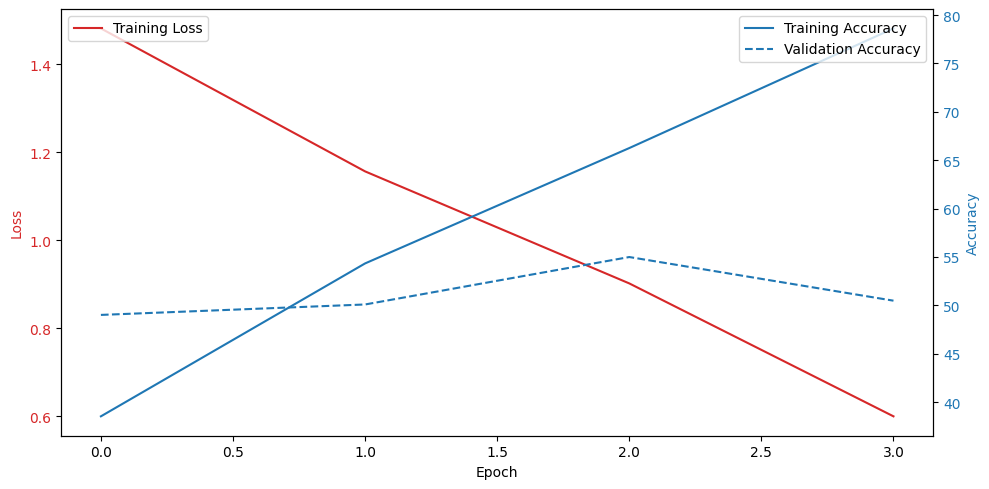

In [25]:
def plot_metrics(train_losses, train_accuracies, validation_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(train_losses, label="Training Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")

    ax2.plot(train_accuracies, label="Training Accuracy", color="tab:blue")
    ax2.plot(
        validation_accuracies,
        label="Validation Accuracy",
        linestyle="--",
        color="tab:blue",
    )
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()
    fig.savefig(f"{data_path}/report/metrics.png")


plot_metrics(train_losses, train_accuracies, validation_accuracies)

# ☁️ Upload to Hugging Face


In [26]:
if validation_accuracies[-1] > 70.0:
    repository_name = "PunGrumpy/music-genre-classification"

    config = json.dumps(model.config.__dict__)

    model.push_to_hub(repository_name, token=True, config=config)
    tokenizer.push_to_hub(repository_name, token=True)
    print(f"Model pushed to {repository_name}")

# 🛟 Save Model and Tokenizer


In [27]:
model_path = f"{data_path}/model"

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

Model saved to .//model
